## Package Import

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
from ta.momentum import RSIIndicator, ROCIndicator
from ta.trend import MACD
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import matplotlib.pyplot as plt
import warnings
import joblib
from utils import *
warnings.filterwarnings('ignore')

## Random Seed Setup

In [3]:
# Set a random seed to ensure repeatable results
np.random.seed(42)
tf.random.set_seed(42)

## Data Import

In [4]:
# Load data
data_path = os.path.dirname(os.getcwd()) + '/data'
data_prefix = '/broad_assets_'

target_file = data_path + data_prefix + 'weekly_rets.xlsx'
lag1_file = data_path + data_prefix + 'lag1_rets.xlsx'
roc_file = data_path + data_prefix + 'roc_52w.xlsx'
macd_file = data_path + data_prefix + 'macd.xlsx'
rsi_file = data_path + data_prefix + 'rsi.xlsx'
ewma_file = data_path + data_prefix + 'ewma_vol.xlsx'
skew_file = data_path + data_prefix + 'skew.xlsx'
kurtosis_file = data_path + data_prefix + 'kurtosis.xlsx'

names = ['target', 'lag1', 'roc', 'macd', 'rsi', 'ewma', 'skew', 'kurtosis']
files = [target_file, lag1_file, roc_file, macd_file, rsi_file, ewma_file, skew_file, kurtosis_file]
dfs = {}
for name, file in zip(names, files):
    dfs[name] = pd.read_excel(file, sheet_name=0, index_col=0, parse_dates=True)

In [5]:
# Get intersection of dates across datasets
dates_inter = reduce(lambda x, y: set(x).intersection(y.index), list(dfs.values())[1:], list(dfs.values())[0].index)
dates_inter = sorted(list(dates_inter))
print(f'Count: {len(dates_inter)}\nFirst: {dates_inter[0]}\nLast:{dates_inter[-1]}')

Count: 1101
First: 2003-08-11 00:00:00
Last:2024-09-06 00:00:00


In [6]:
for name, frame in dfs.items():
    dfs[name] = frame.loc[dates_inter]

## Dynamic Rolling Quantile Risk Level Assignments

$$\text{Portfolio Volatility} = \sqrt{\sum^n_{i = 1}\sum^n_{j = 1}\omega_i\omega_j Cov(\sigma_i, \sigma_j)}$$
Equal weights in default.

In [7]:
def calculate_rolling_volatility(df, return_columns, window):
    """
    Calculate rolling volatility for each asset over a specified window.
    
    :param df: DataFrame containing return data
    :param return_columns: List of columns representing asset returns
    :param window: The rolling window period to calculate the volatility
    :return: DataFrame with rolling volatilities for each asset
    """
    vol_df = pd.DataFrame(index=df.index)
    
    for col in return_columns:
        # Calculate rolling standard deviation (volatility) for the given window
        vol_df[f'{col}_Vol'] = df[col].rolling(window=window).std()
    
    return vol_df.dropna()

def calculate_portfolio_volatility(df, asset_columns, window=52, weights=None):
    # Ensure the index is datetime, as 'Date' is used as the index
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df['Date'])
    
    num_assets = len(asset_columns)
    
    # Assign equal weights if no weights are provided
    if weights is None:
        weights = np.ones(num_assets) / num_assets
    
    # Ensure weights sum to 1
    weights = np.array(weights)
    if not np.isclose(weights.sum(), 1):
        raise ValueError("Weights must sum to 1.")
    
    # Covariance Matrix
    rolling_cov = df[asset_columns].rolling(window=window).cov()

    portfolio_volatility = []

    for i in range(window, len(df)):
        # Extract the covariance matrix for the current time point
        cov_matrix = rolling_cov.loc[df.index[i]].values.reshape((num_assets, num_assets))

        # Calculate the portfolio variance (weights * cov_matrix * weights.T)
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

        # Calculate the portfolio volatility (square root of variance)
        portfolio_volatility.append(np.sqrt(portfolio_variance))

    portfolio_volatility_series = pd.Series(portfolio_volatility, index=df.index[window:])

    return portfolio_volatility_series

asset_columns = [col for col in dfs['ewma'].columns if col.startswith('EWMA_vol_')]
rolling_window_size = 26 # Set the rolling window to be half year.

# Function to calculate rolling quantiles for volatility thresholds
def calculate_rolling_quantiles(df, asset_columns, window=13, quantiles=[0.1, 0.3, 0.7, 0.9]):
    """
    Calculate rolling quantiles for portfolio volatility over a given window.
    
    :param df: DataFrame containing volatility data
    :param asset_columns: List of columns representing asset volatilities
    :param window: Rolling window period (default is 0.5 year, assuming weekly data, i.e., 26 weeks)
    :param quantiles: Quantiles to calculate for the rolling volatility (default [0.1, 0.3, 0.7, 0.9])
    :return: DataFrame of rolling quantiles
    """
    rolling_quantiles_df = pd.DataFrame(index=df.index[window:], columns=quantiles)
    
    for i in range(window, len(df)):
        rolling_data = df.iloc[i-window:i]
        rolling_volatility = calculate_portfolio_volatility(rolling_data, asset_columns, window=13)
        rolling_quantiles = rolling_volatility.quantile(quantiles)
        rolling_quantiles_df.loc[df.index[i]] = rolling_quantiles.values

    return rolling_quantiles_df

def assign_rolling_risk_levels(vol_series, rolling_quantiles):
    risk_levels = []
    
    for i in range(len(vol_series)):
        if i >= len(rolling_quantiles):
            risk_levels.append(None)
        else:
            quantiles = rolling_quantiles.iloc[i]
            vol = vol_series.iloc[i]
            if vol > quantiles[0.9]:
                risk_levels.append('Extremely High Risk')
            elif vol > quantiles[0.7]:
                risk_levels.append('Moderately High Risk')
            elif vol > quantiles[0.3]:
                risk_levels.append('Moderately Low Risk')
            else:
                risk_levels.append('Extremely Low Risk')
    
    return pd.Series(risk_levels, index=vol_series.index)

In [12]:
ewma_weekly_vol = dfs['ewma'].reset_index()
# Filter the data for the time range 2002 to 2024
period_data = ewma_weekly_vol[(ewma_weekly_vol['Date'] >= '2003-08-11') & (ewma_weekly_vol['Date'] <= '2024-12-31')]
# Calculate portfolio volatility for the test period
volatility_series = calculate_portfolio_volatility(period_data, asset_columns, window=13)
# Calculate rolling quantiles for the test period with 0.5-year rolling window
rolling_quantile_thresholds = calculate_rolling_quantiles(period_data, asset_columns, window=rolling_window_size)
# Assign risk levels for the test period using rolling quantiles
rolling_risk_levels = assign_rolling_risk_levels(volatility_series, rolling_quantile_thresholds)

In [13]:
# display(rolling_risk_levels.head(), volatility_series)
risk_levels_df = pd.DataFrame({'Portfolio Volatility': volatility_series, 'Risk Level': rolling_risk_levels})
display(risk_levels_df)

,Portfolio Volatility,Risk Level
Date,,
2003-11-10,0.0024,Moderately Low Risk
2003-11-17,0.0024,Moderately High Risk
2003-11-24,0.0024,Moderately High Risk
2003-12-01,0.0022,Moderately Low Risk
2003-12-08,0.0023,Moderately High Risk
...,...,...
2024-08-12,0.0065,None
2024-08-19,0.0070,None
2024-08-26,0.0072,None


## Features Import

### Feature adjustments based on the Generated Raw Data

In [52]:
# RSI
df_rsi = dfs['rsi']
df_rsi.columns = [f"RSI_Asset {i+1}" for i in range(len(dfs['rsi'].columns))]
# ROC
df_roc = dfs['roc']
# MACD
macd_columns = [col for col in dfs['macd'].columns if 'MACD_Line' in col]
df_macd = dfs['macd'][macd_columns]
# EWMA VOL
df_vol = dfs['ewma']
# SKEW
df_skew = dfs['skew']
df_skew.columns = [f"SKEW_Asset {i+1}" for i in range(len(dfs['skew'].columns))]
# KURTOSIS
df_kurtosis = dfs['kurtosis']
df_kurtosis.columns = [f"KURTOSIS_Asset {i+1}" for i in range(len(dfs['kurtosis'].columns))]

### Features Wrapping Up

In [88]:
# Features: RSI, ROC, MACD, EWMA, SKEW, KURTOSIS

combined_df = pd.concat([df_rsi, df_roc, df_macd, df_vol, df_skew, df_kurtosis], axis=1)
metrics_order = ["RSI", "ROC", "MACD_Line", "EWMA_vol", "SKEW", "KURTOSIS"]
# Extract unique asset numbers and metrics from the column names
unique_assets = sorted(set(int(col.split()[-1]) for col in combined_df.columns))
# Generate the correctly ordered columns for each asset by grouping them directly
ordered_columns = [f"{metric}_Asset {asset}" for asset in unique_assets for metric in metrics_order]
# Select only the columns that exist in the data
valid_columns = [col for col in ordered_columns if col in combined_df.columns]
# Reorder the dataframe columns based on this direct, valid list
features = combined_df[valid_columns].dropna()

final_df = pd.concat([features, risk_levels_df], axis = 1)
final_df = final_df.dropna()
final_df

In [79]:
df_target = dfs['target'].loc[final_df.index]  # Adjust the original returns data aligning with the final features data

1. Use previous 20-week returns to predict the next week return.
2. Target variables are converted to binary: 1 for positive returns and 0 for negative returuns.
3. Training & Testing dataset split: 80\% for training and 20\% for testing.

In [94]:
sequence_length = 20
models = {}
scalers = {}
histories = {}
predictions = {}
binary_predictions = {}
test_dates = None  # Store the dates in the testing set

# Define the columns of features to be used for model training, excluding non-numeric or unnecessary columns
feature_columns = [col for col in final_df.columns if col not in ['Portfolio Volatility', 'Risk Level']]

def create_sequences(features, target, seq_length):
    X = []
    y = []
    for i in range(len(features) - seq_length):
        X.append(features[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

In [95]:
feature_columns

['RSI_Asset 1',
 'ROC_Asset 1',
 'MACD_Line_Asset 1',
 'EWMA_vol_Asset 1',
 'SKEW_Asset 1',
 'KURTOSIS_Asset 1',
 'RSI_Asset 2',
 'ROC_Asset 2',
 'MACD_Line_Asset 2',
 'EWMA_vol_Asset 2',
 'SKEW_Asset 2',
 'KURTOSIS_Asset 2',
 'RSI_Asset 3',
 'ROC_Asset 3',
 'MACD_Line_Asset 3',
 'EWMA_vol_Asset 3',
 'SKEW_Asset 3',
 'KURTOSIS_Asset 3',
 'RSI_Asset 4',
 'ROC_Asset 4',
 'MACD_Line_Asset 4',
 'EWMA_vol_Asset 4',
 'SKEW_Asset 4',
 'KURTOSIS_Asset 4',
 'RSI_Asset 5',
 'ROC_Asset 5',
 'MACD_Line_Asset 5',
 'EWMA_vol_Asset 5',
 'SKEW_Asset 5',
 'KURTOSIS_Asset 5',
 'RSI_Asset 6',
 'ROC_Asset 6',
 'MACD_Line_Asset 6',
 'EWMA_vol_Asset 6',
 'SKEW_Asset 6',
 'KURTOSIS_Asset 6',
 'RSI_Asset 7',
 'ROC_Asset 7',
 'MACD_Line_Asset 7',
 'EWMA_vol_Asset 7',
 'SKEW_Asset 7',
 'KURTOSIS_Asset 7',
 'RSI_Asset 8',
 'ROC_Asset 8',
 'MACD_Line_Asset 8',
 'EWMA_vol_Asset 8',
 'SKEW_Asset 8',
 'KURTOSIS_Asset 8',
 'RSI_Asset 9',
 'ROC_Asset 9',
 'MACD_Line_Asset 9',
 'EWMA_vol_Asset 9',
 'SKEW_Asset 9',
 'KU

In [96]:
assets = df_target.columns[0:]
assets

Index(['Asset 1', 'Asset 2', 'Asset 3', 'Asset 4', 'Asset 5', 'Asset 6',
       'Asset 7', 'Asset 8', 'Asset 9', 'Asset 10', 'Asset 11'],
      dtype='object')


Processing Asset 1 ...
Asset 1 - Loss of the testing set: 0.7400, Accuracy: 0.5450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


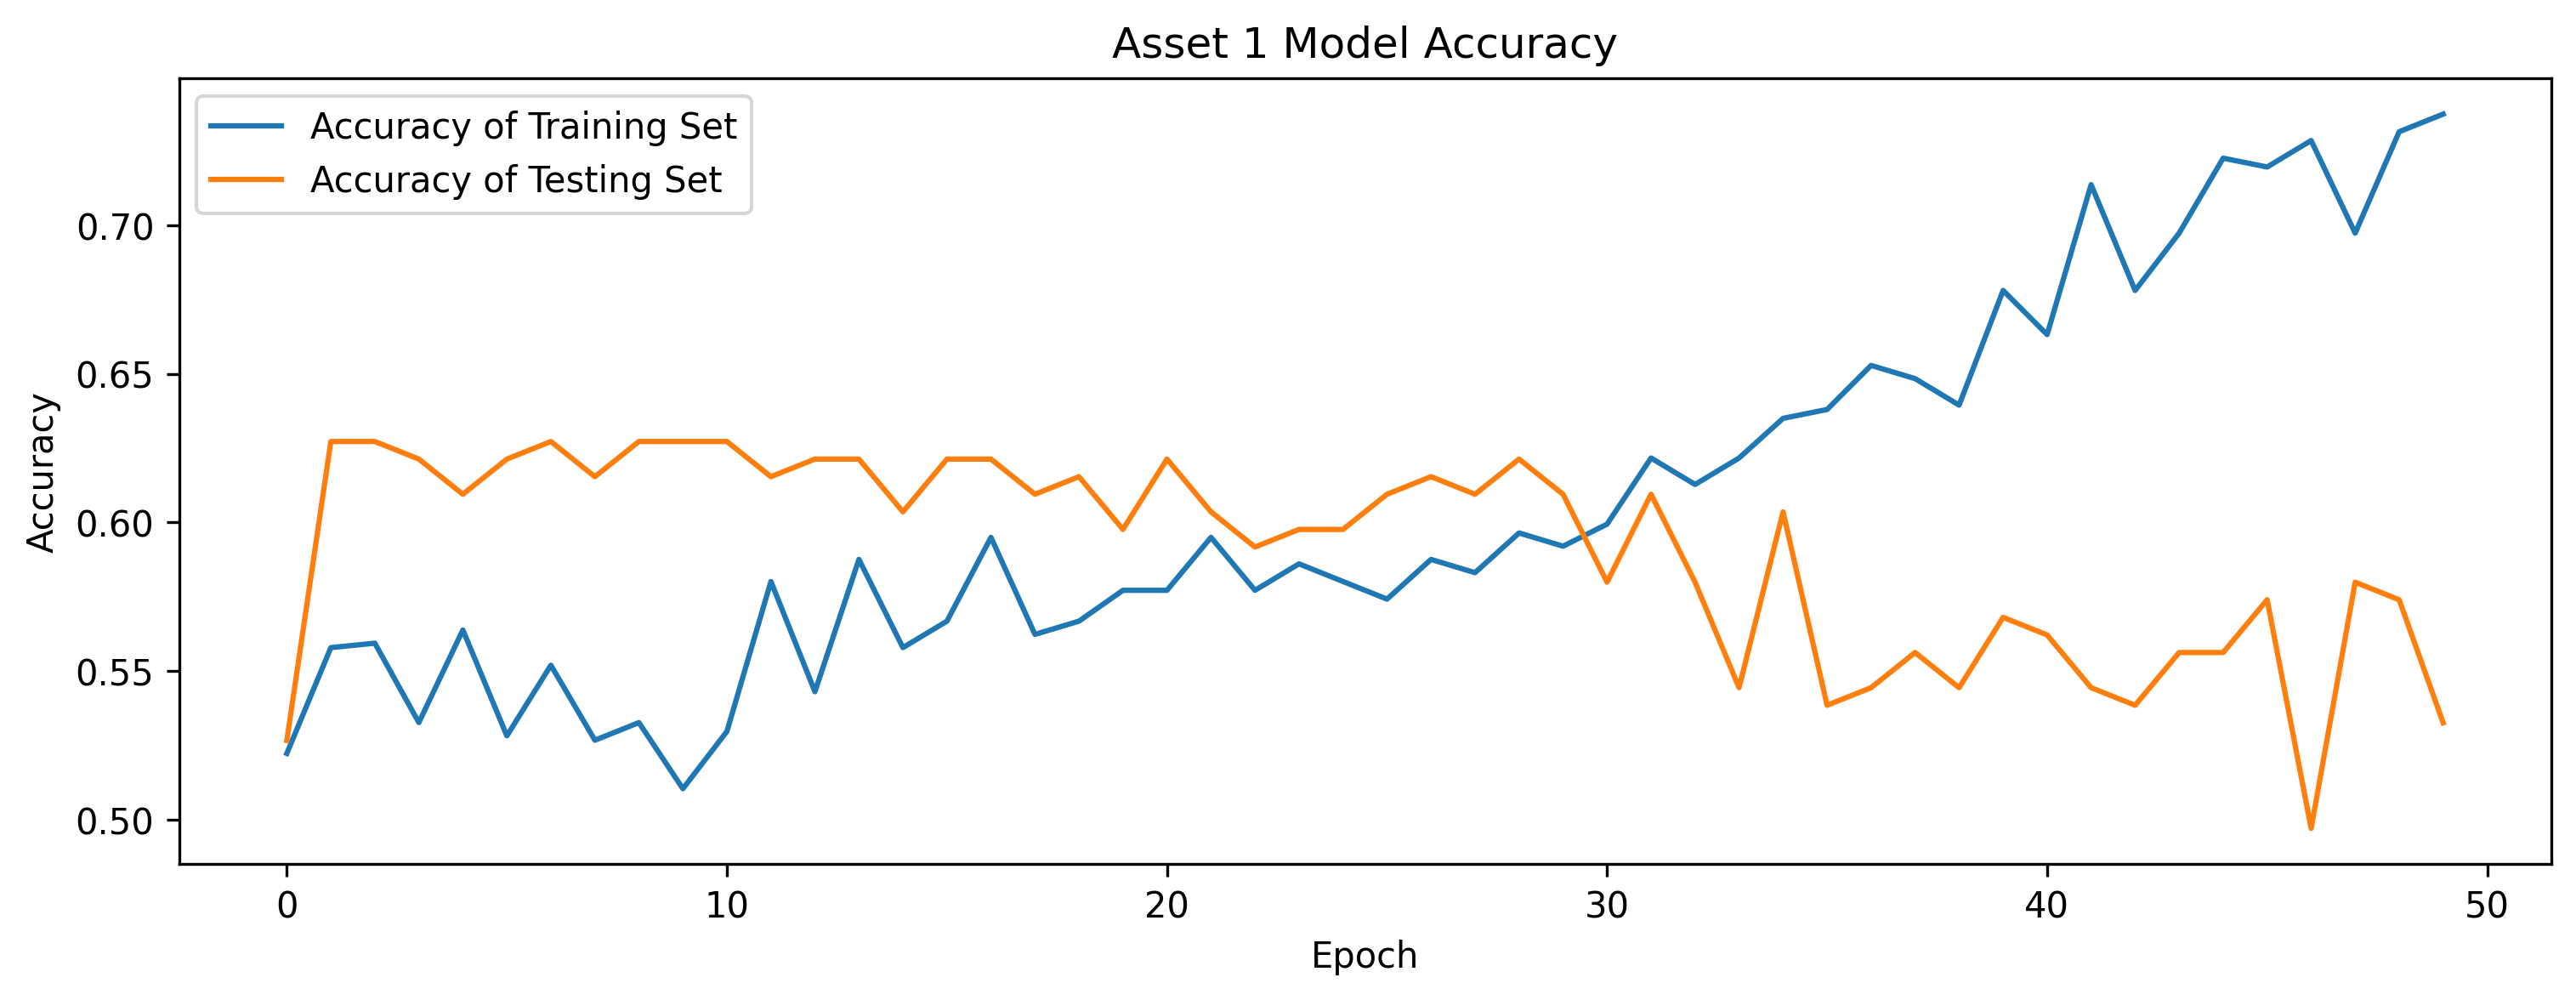


Processing Asset 2 ...
Asset 2 - Loss of the testing set: 0.8360, Accuracy: 0.5071
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


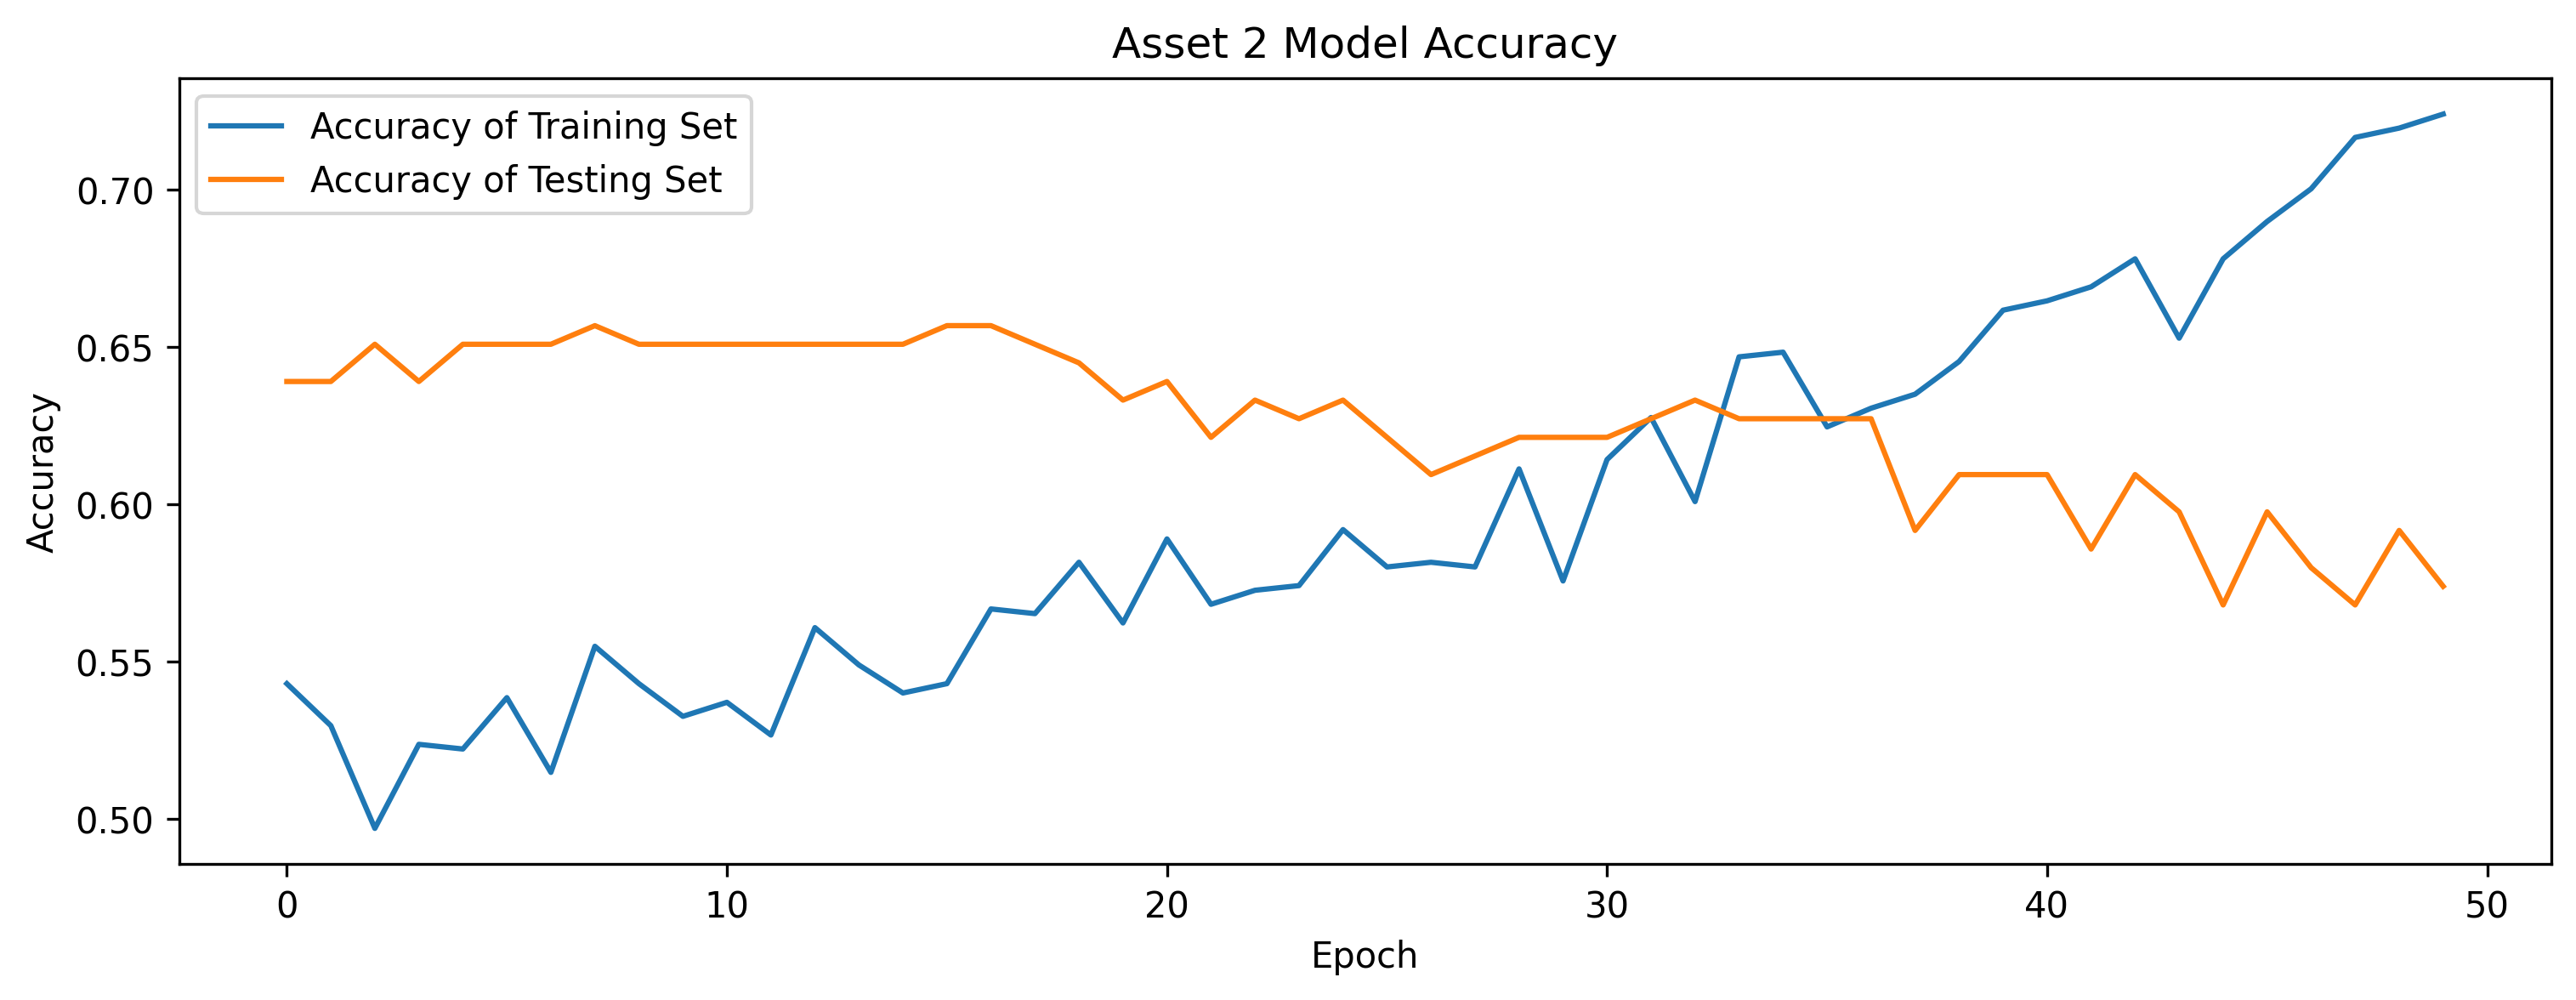


Processing Asset 3 ...
Asset 3 - Loss of the testing set: 0.8219, Accuracy: 0.4834
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


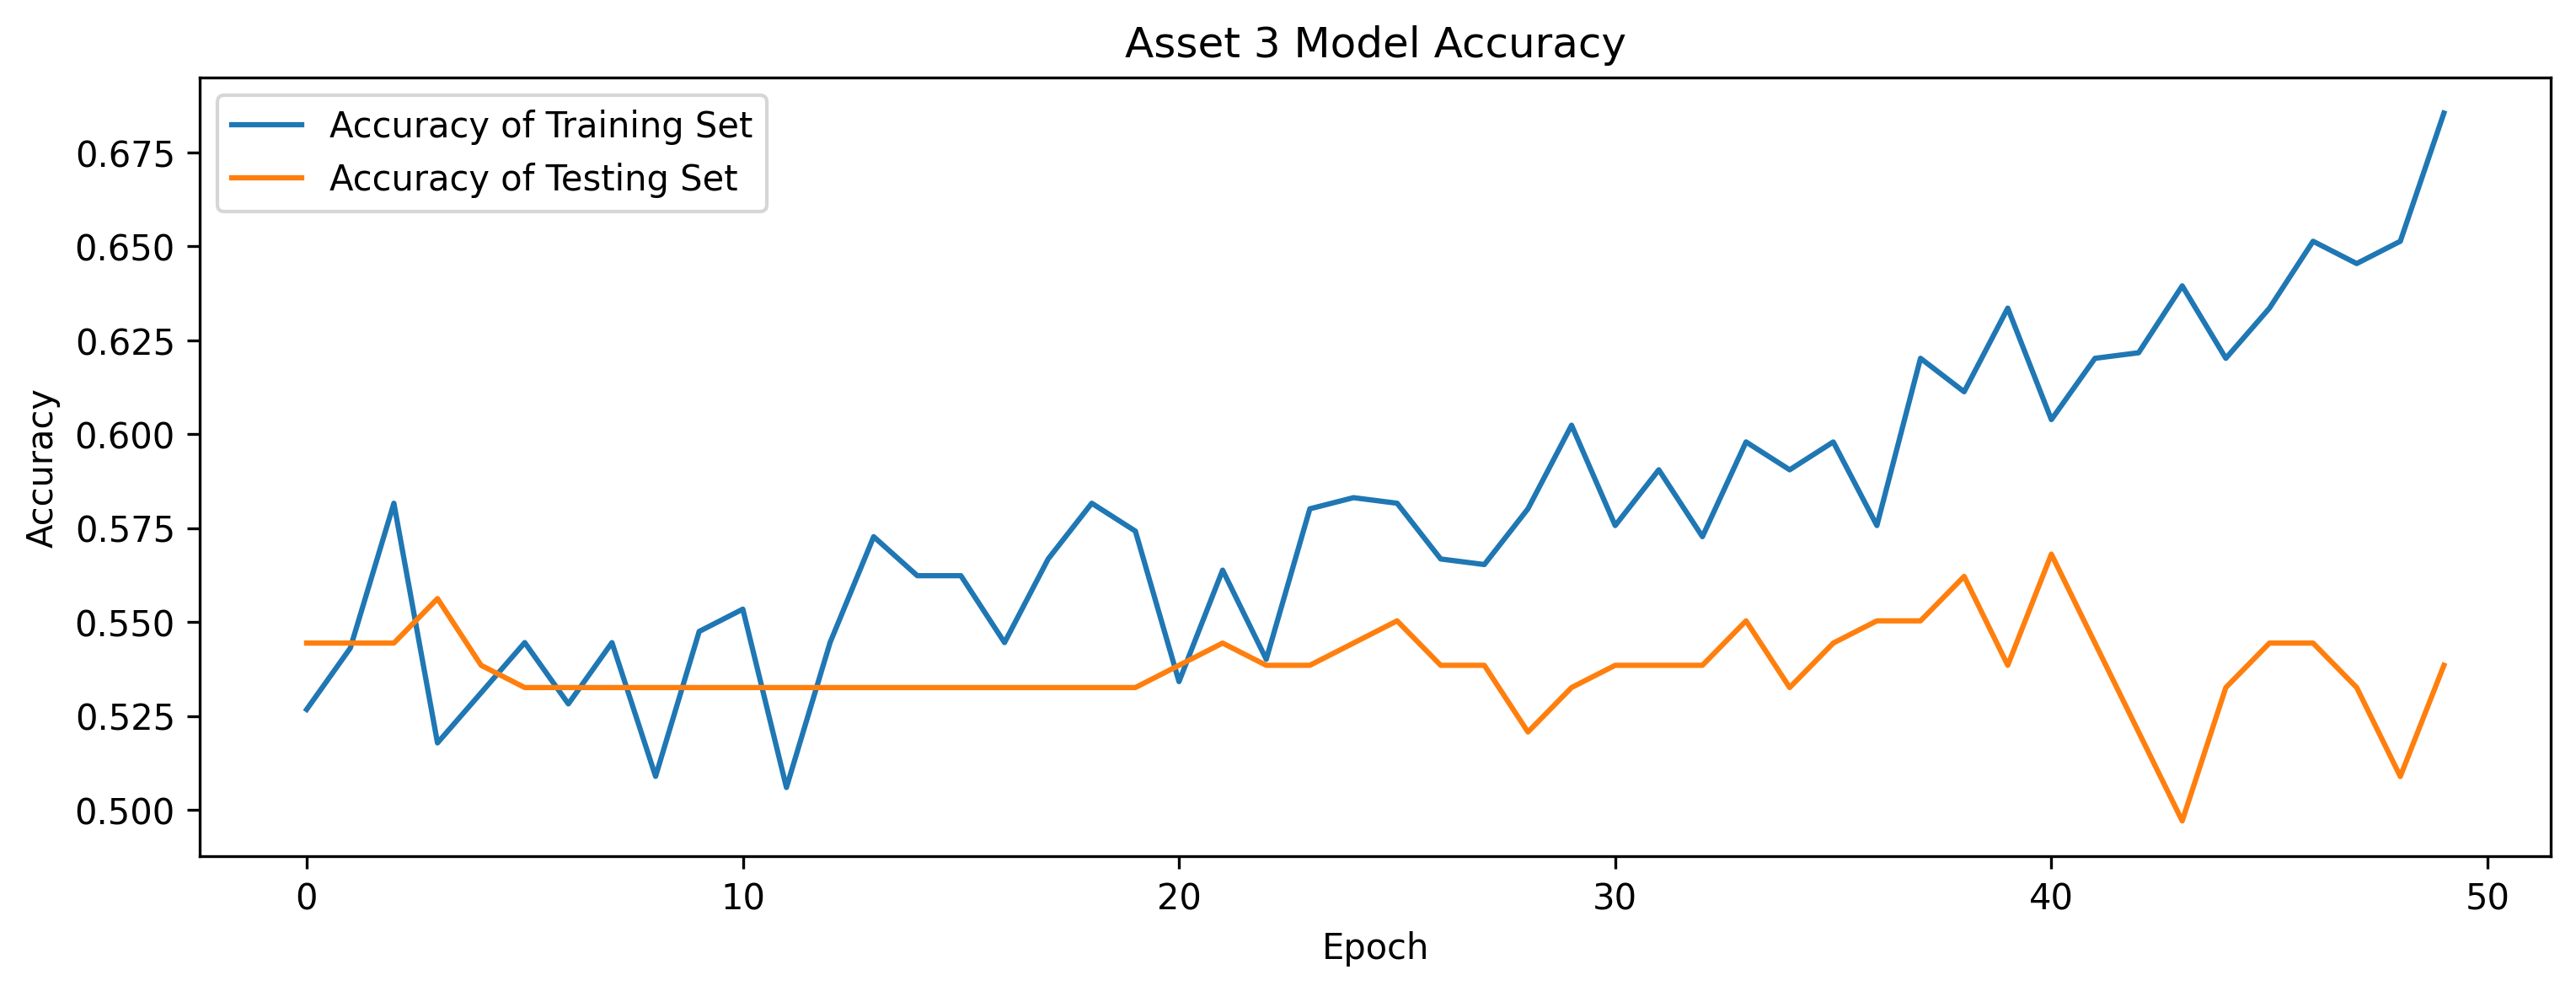


Processing Asset 4 ...
Asset 4 - Loss of the testing set: 0.8878, Accuracy: 0.4550
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


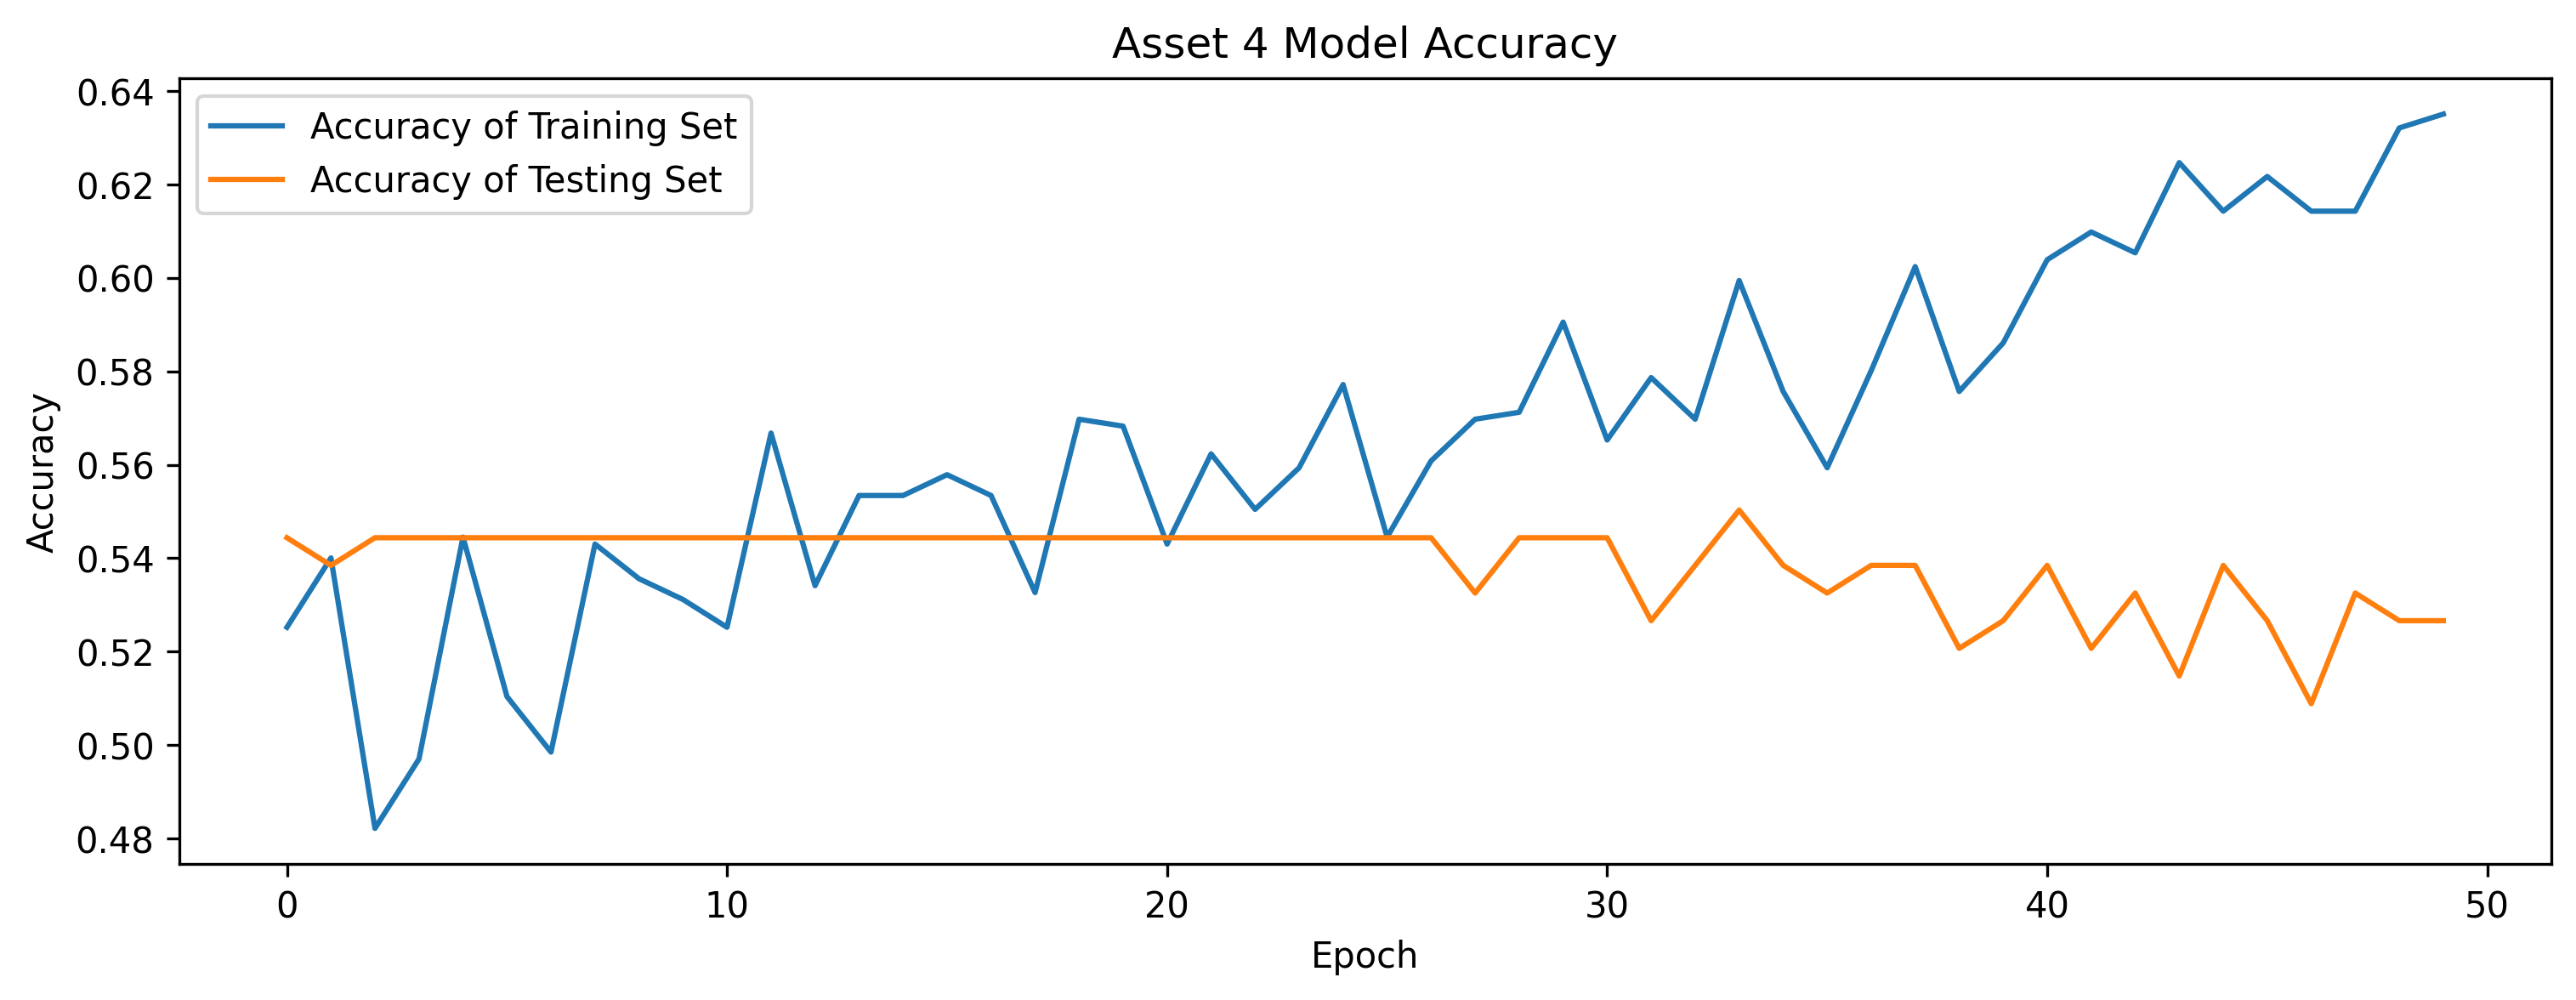


Processing Asset 5 ...
Asset 5 - Loss of the testing set: 0.9725, Accuracy: 0.4550
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


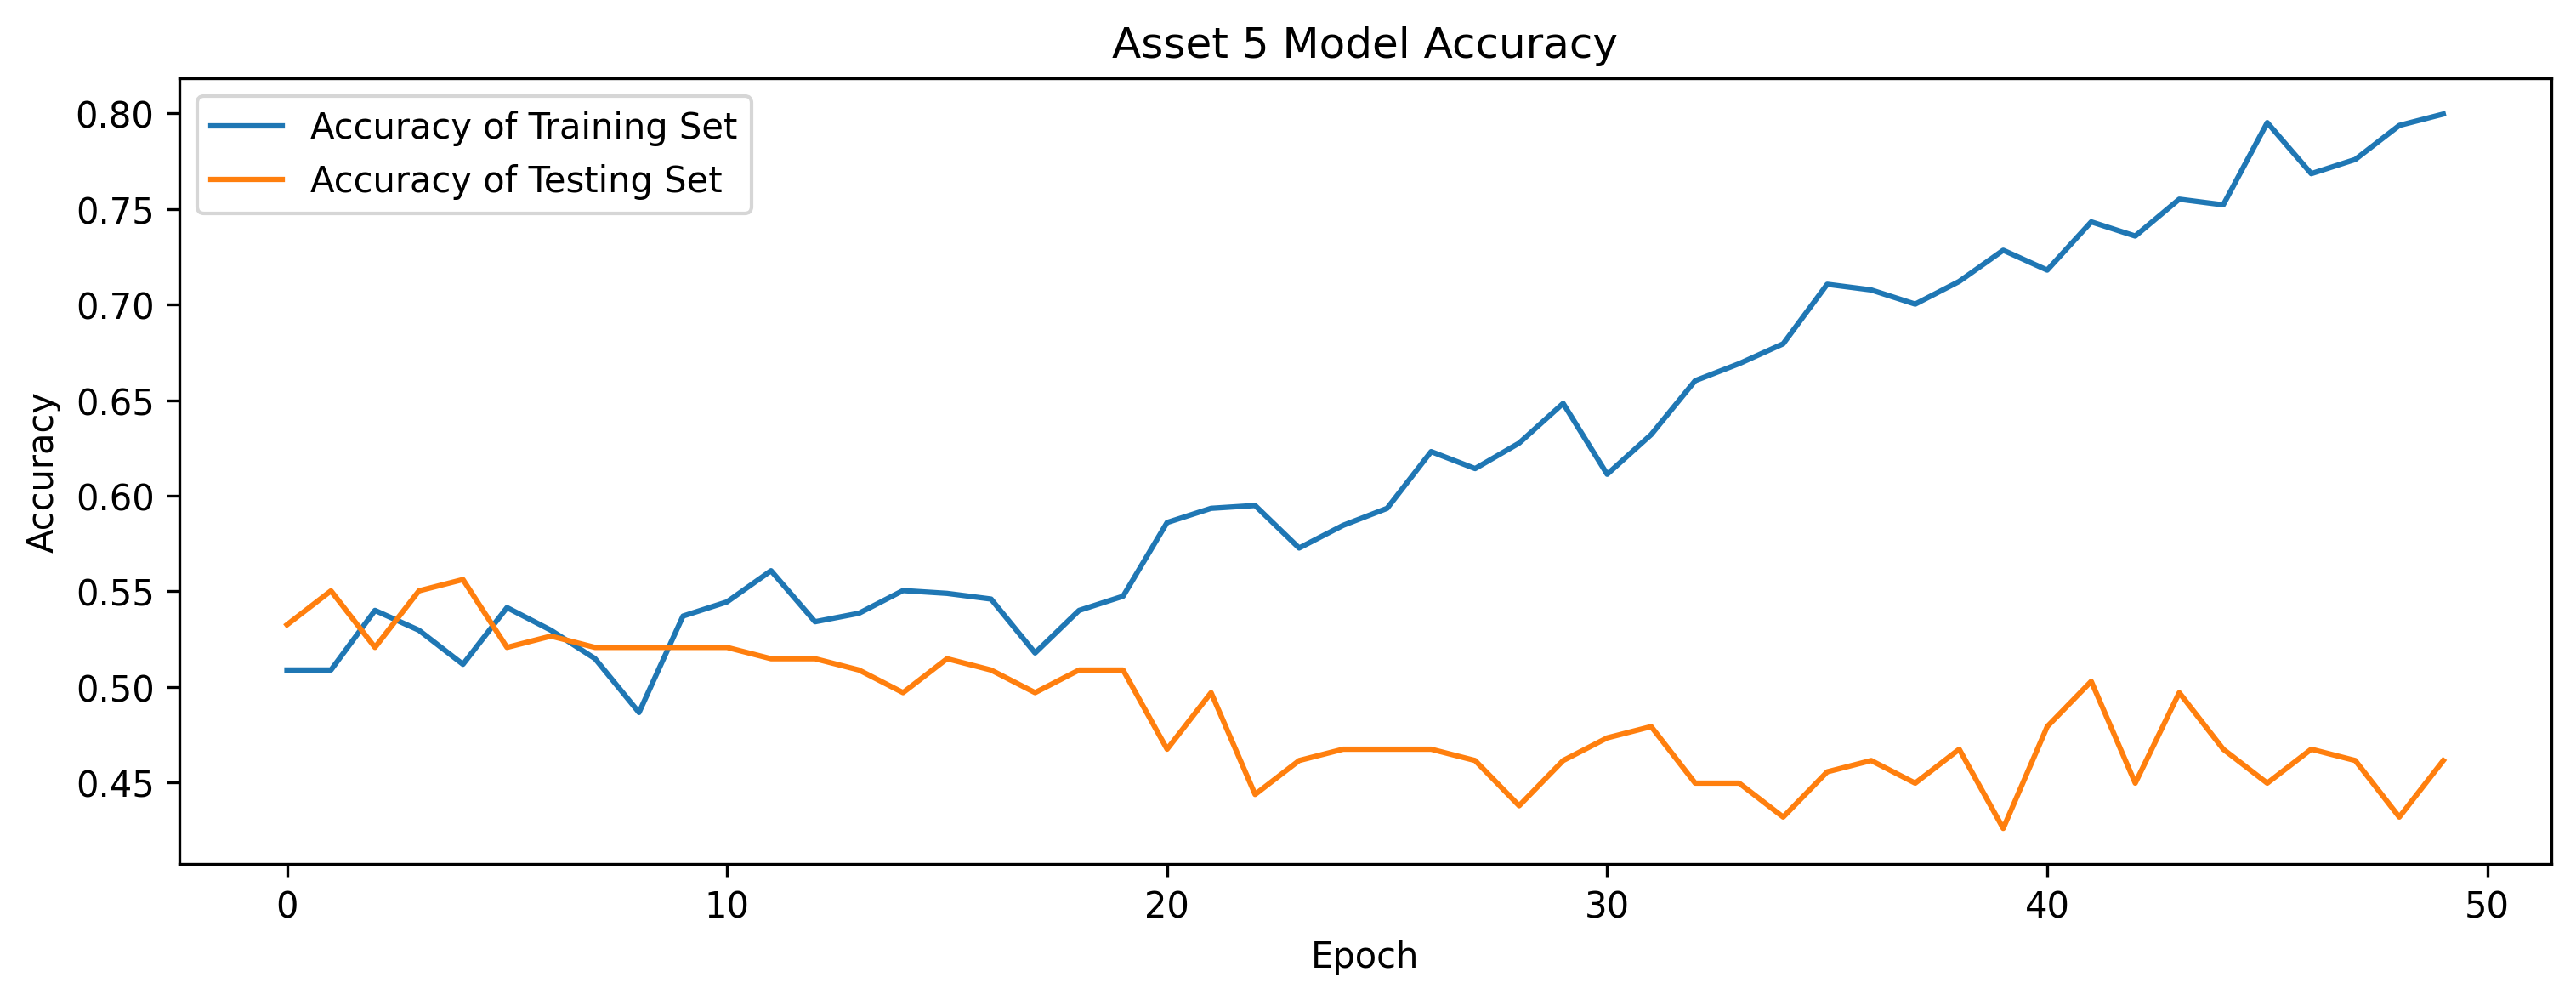


Processing Asset 6 ...
Asset 6 - Loss of the testing set: 0.7391, Accuracy: 0.5166
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


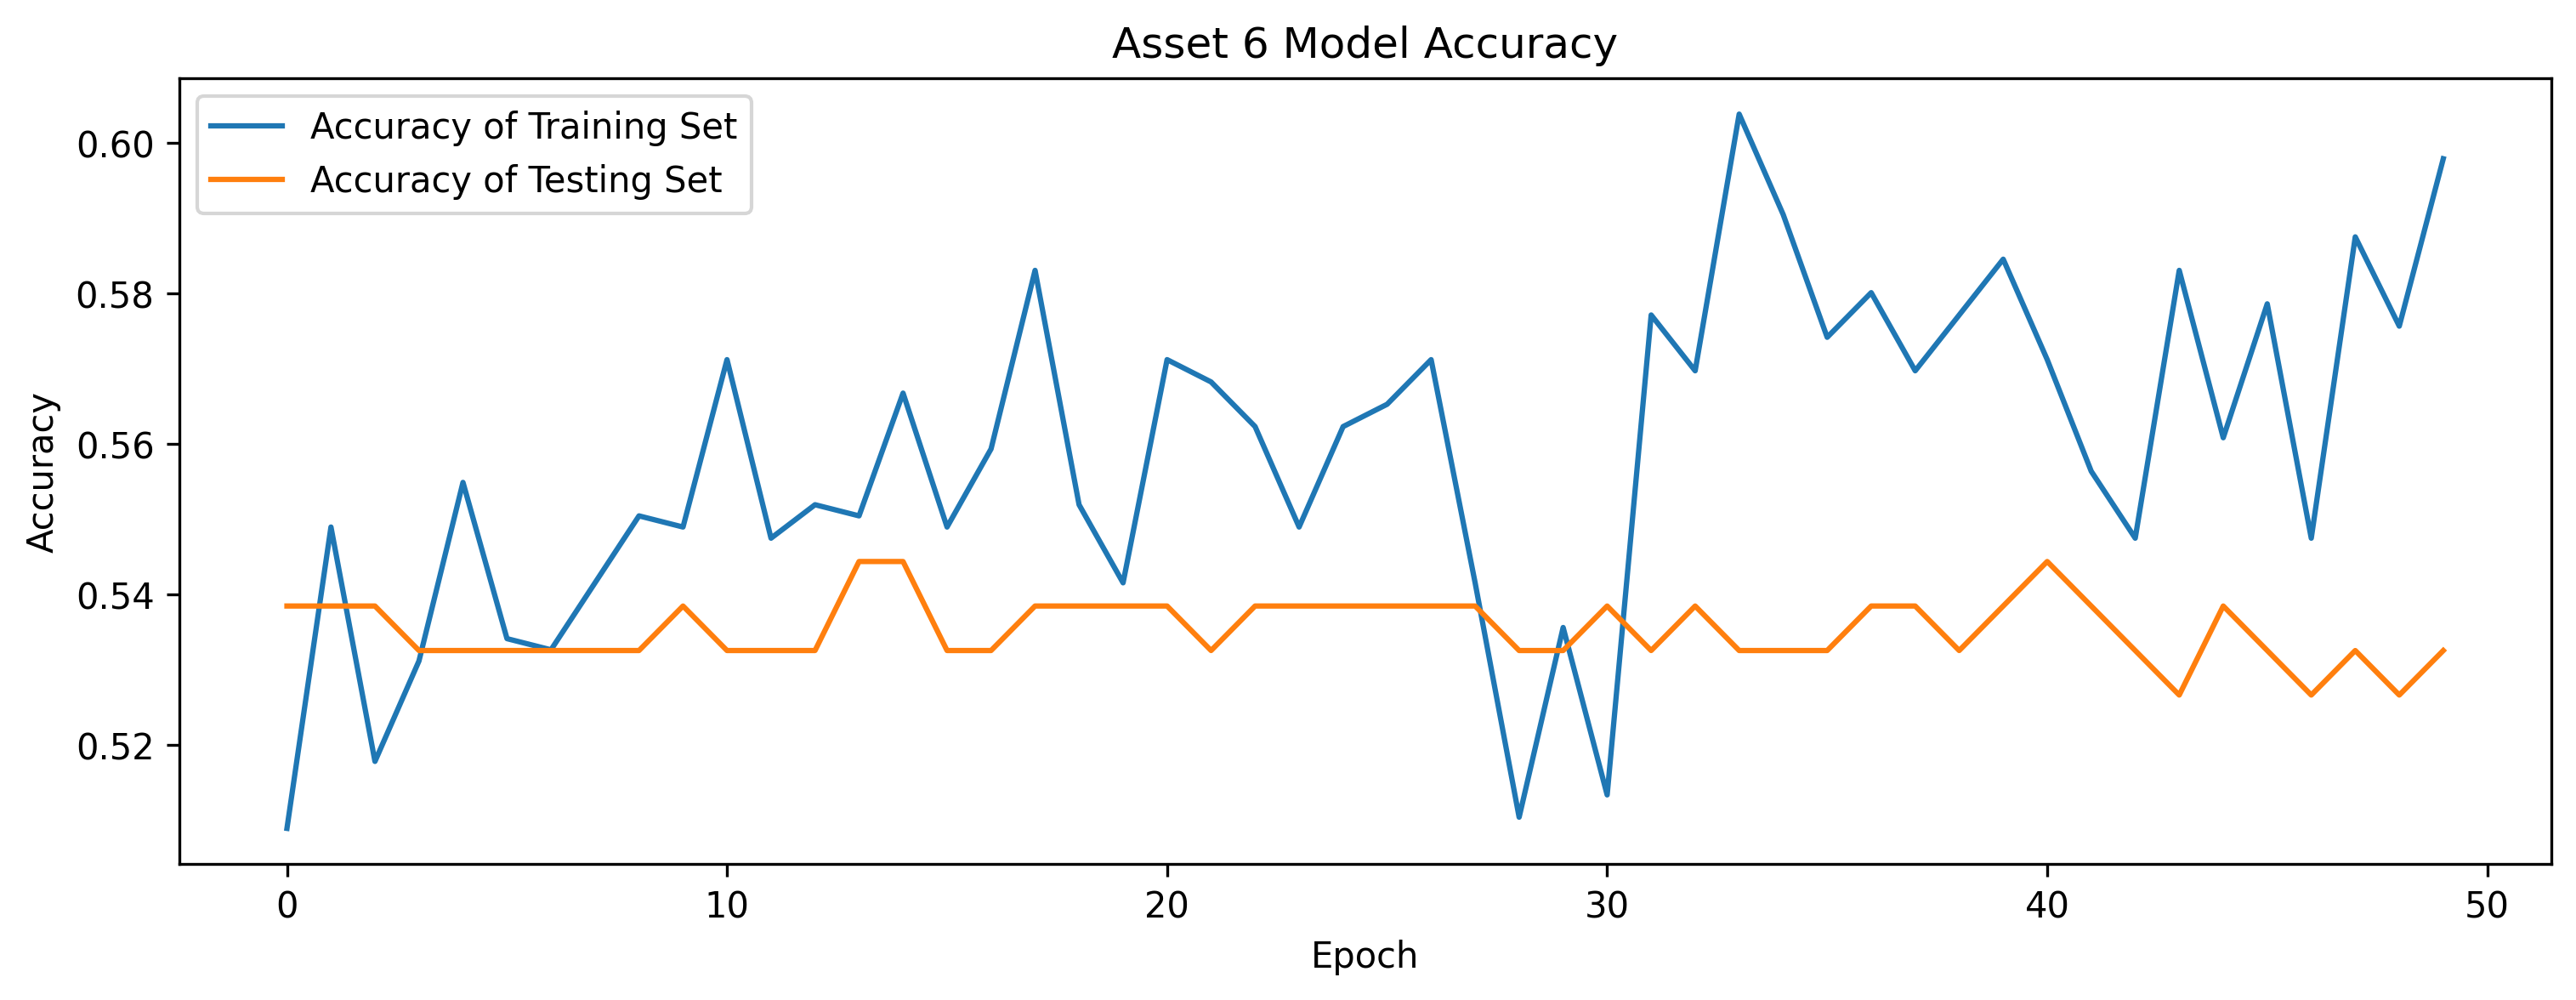


Processing Asset 7 ...
Asset 7 - Loss of the testing set: 0.9045, Accuracy: 0.5118
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


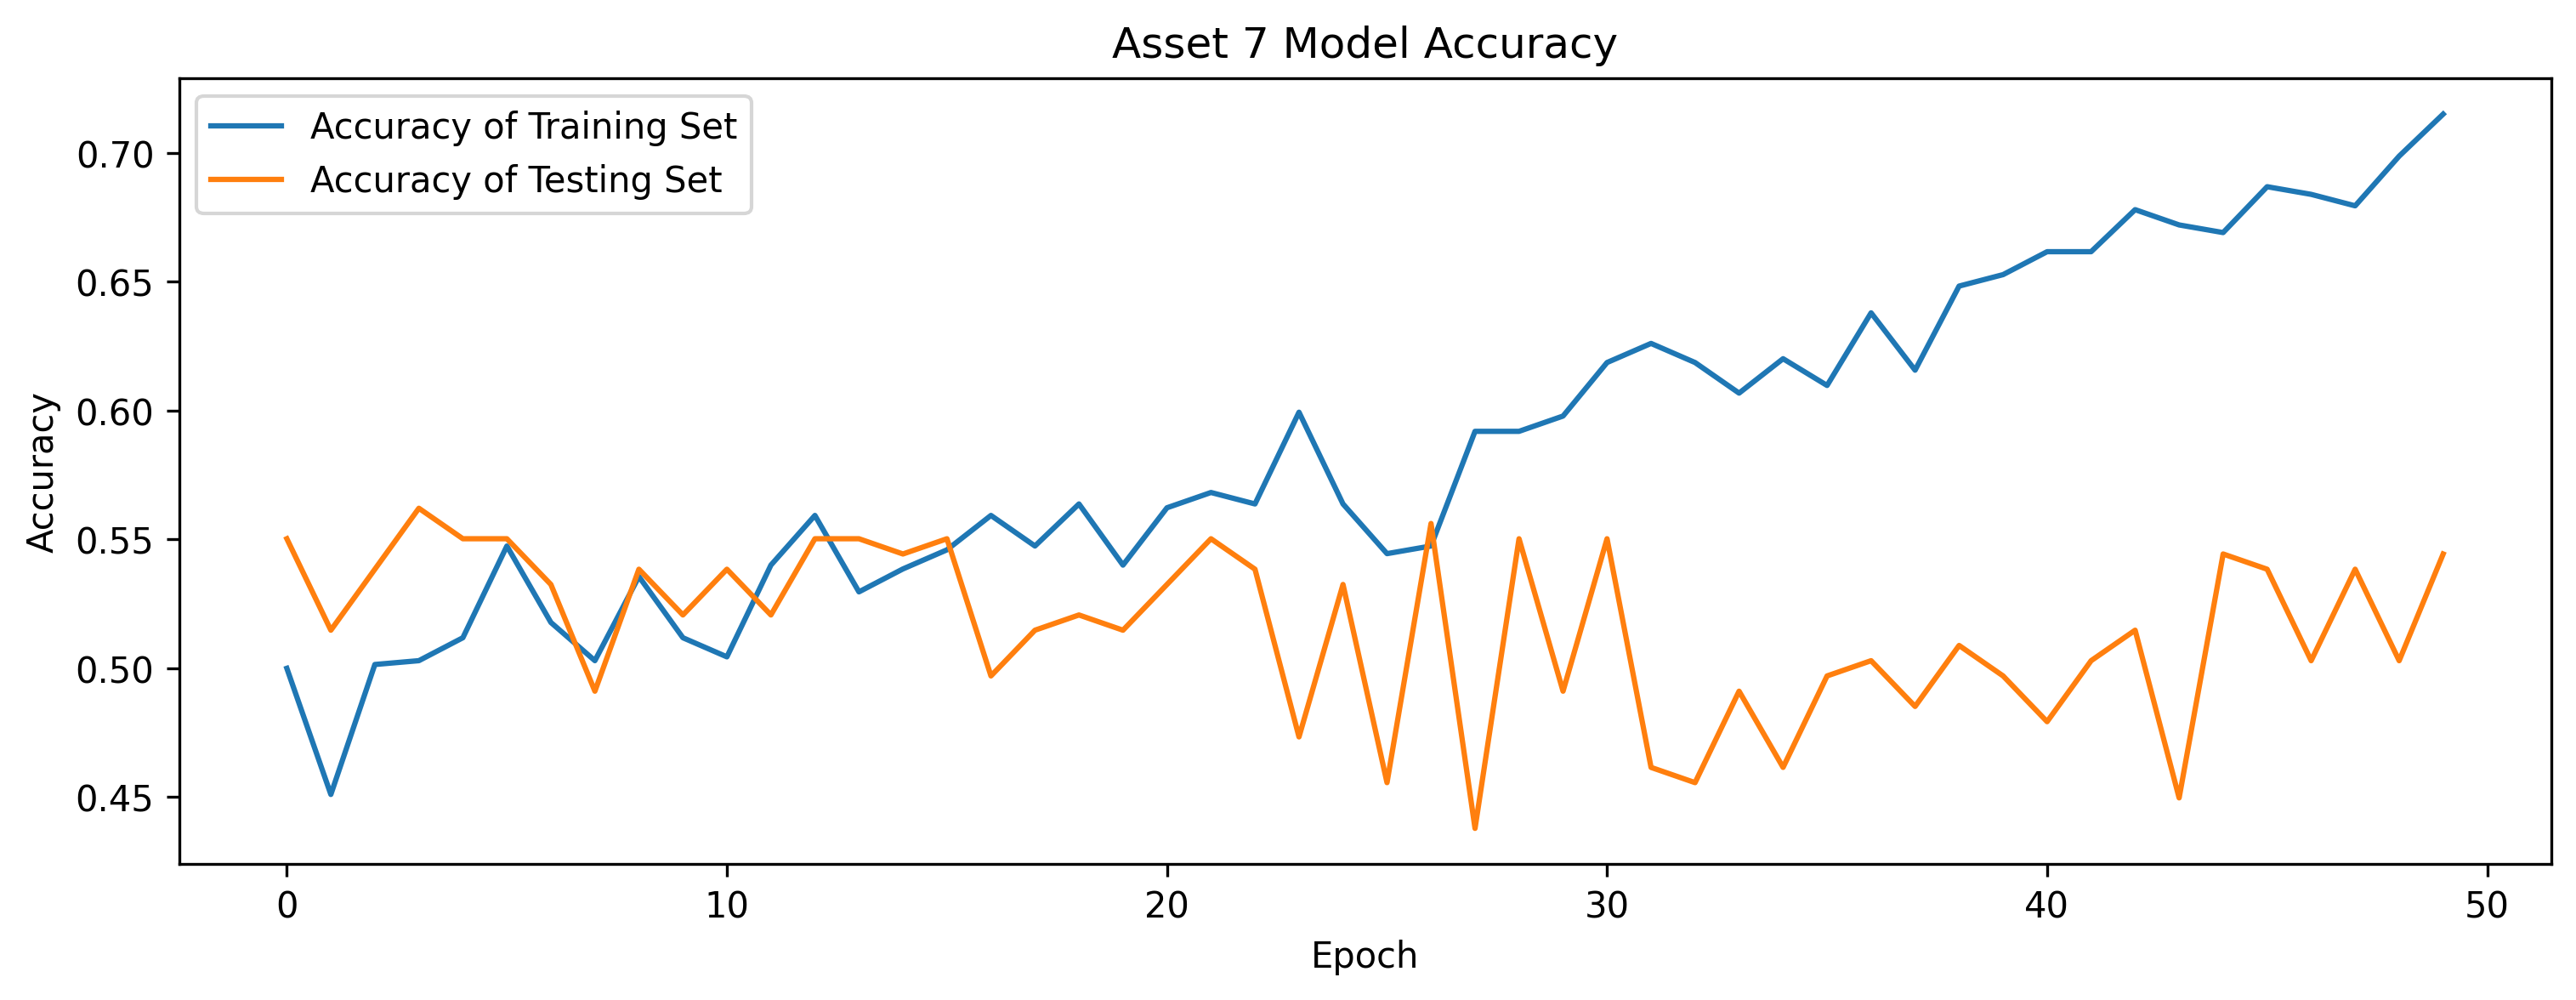


Processing Asset 8 ...
Asset 8 - Loss of the testing set: 0.7803, Accuracy: 0.4645
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


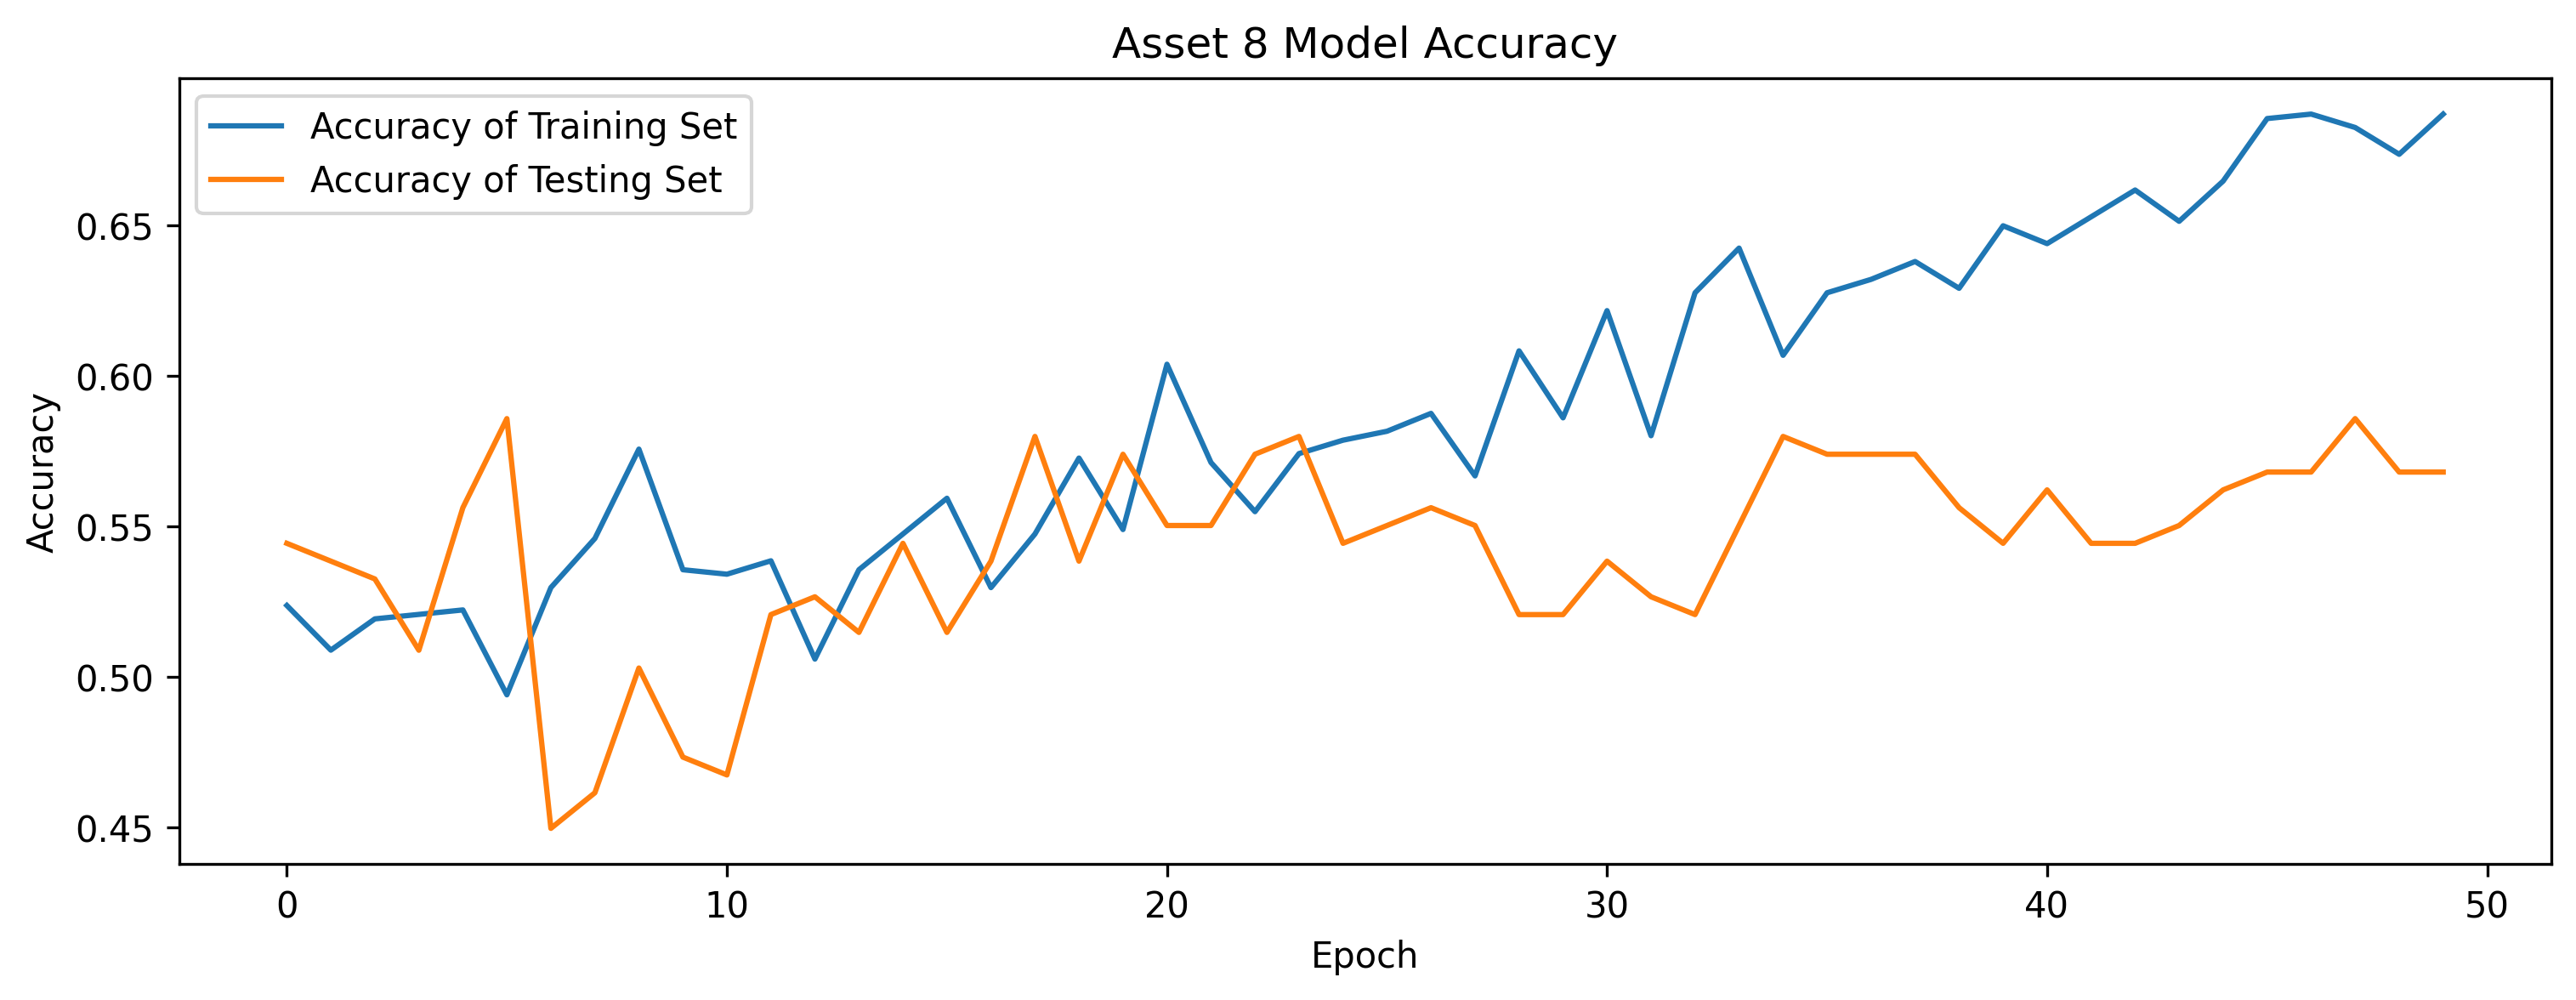


Processing Asset 9 ...
Asset 9 - Loss of the testing set: 0.8100, Accuracy: 0.4645
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


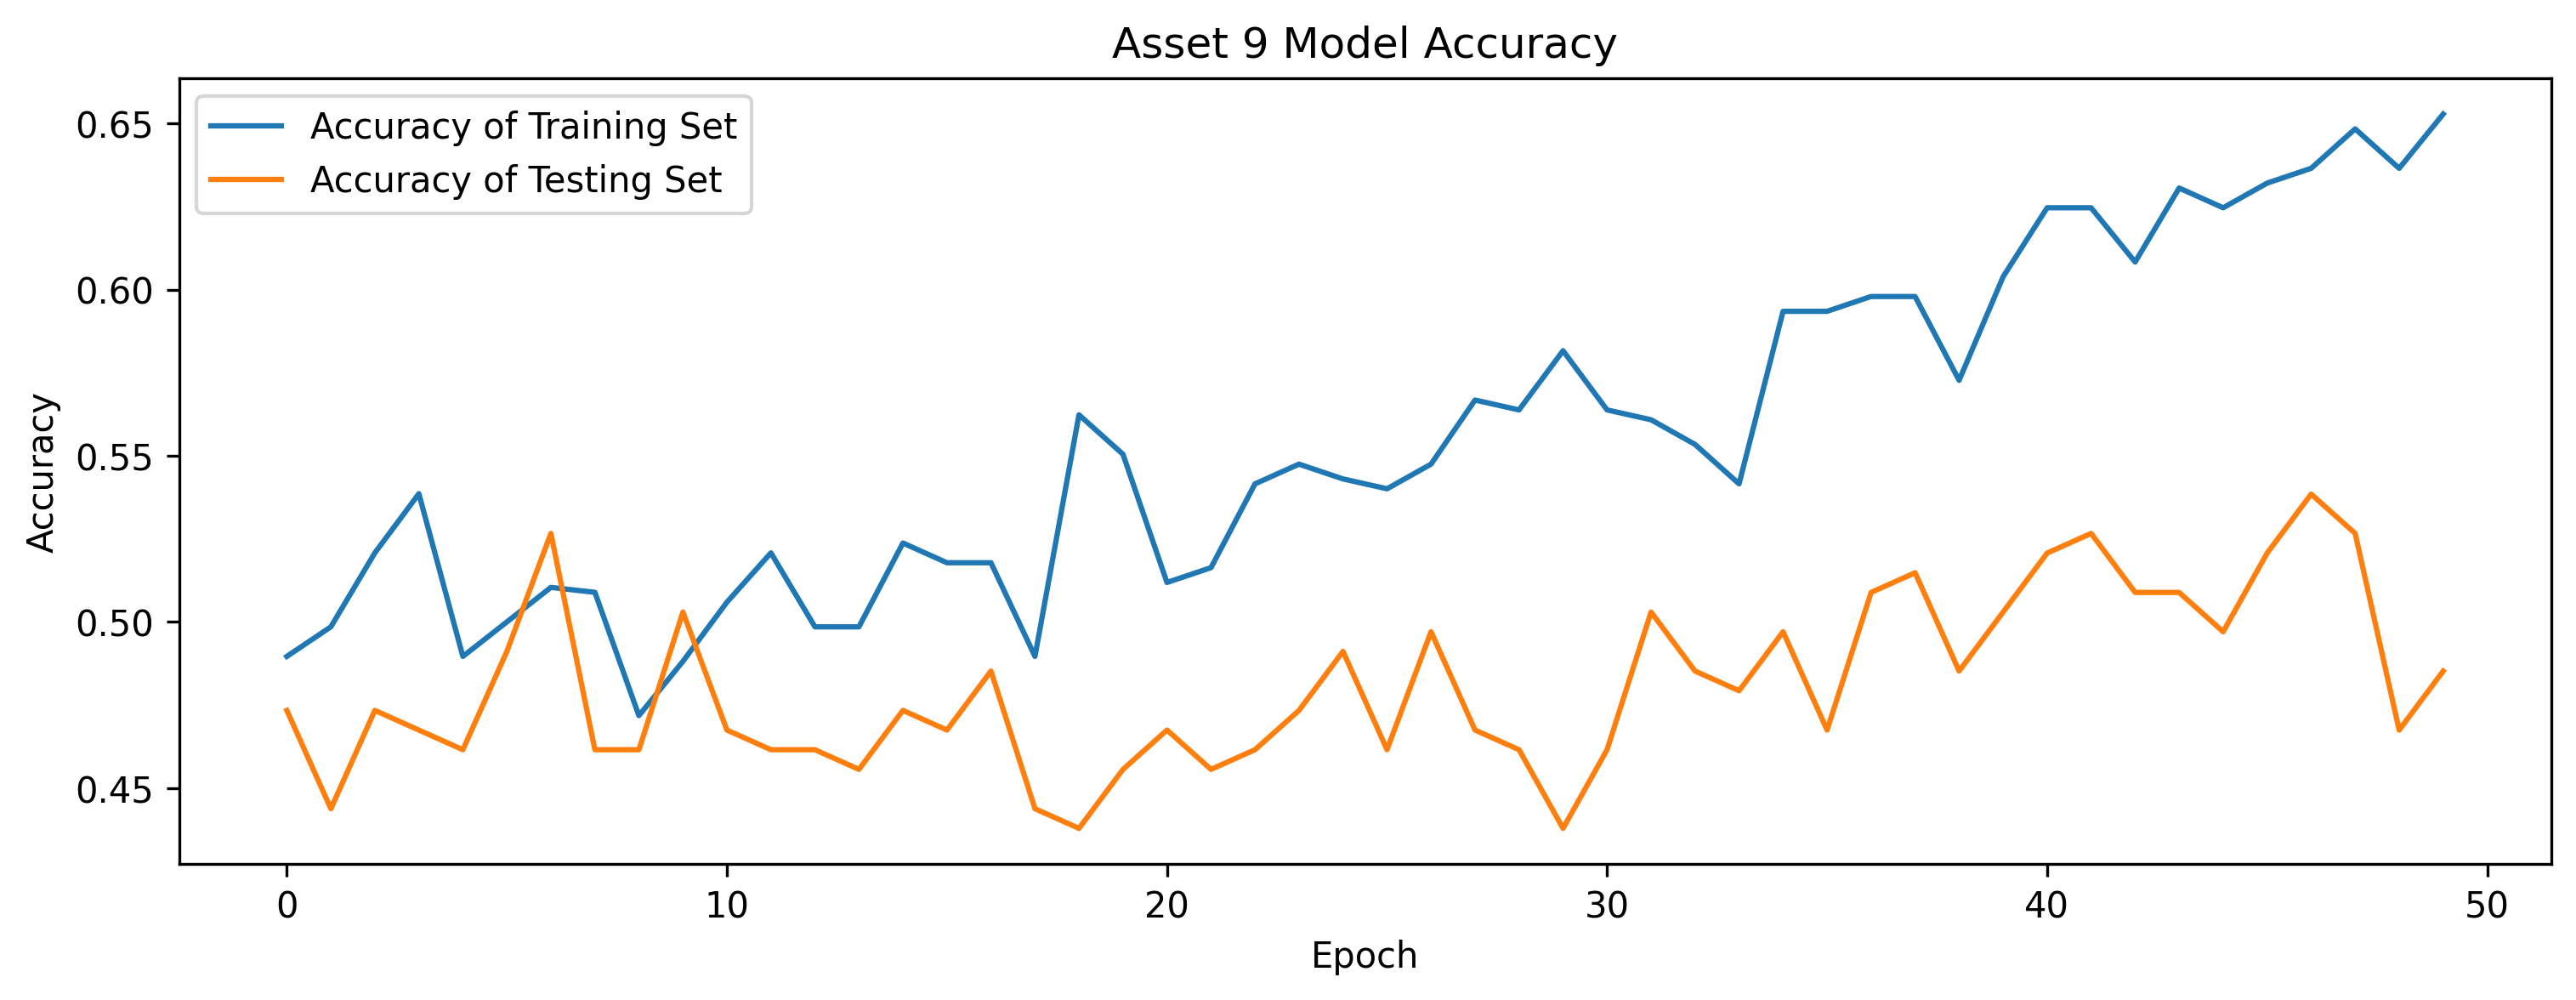


Processing Asset 10 ...
Asset 10 - Loss of the testing set: 0.9813, Accuracy: 0.4929
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


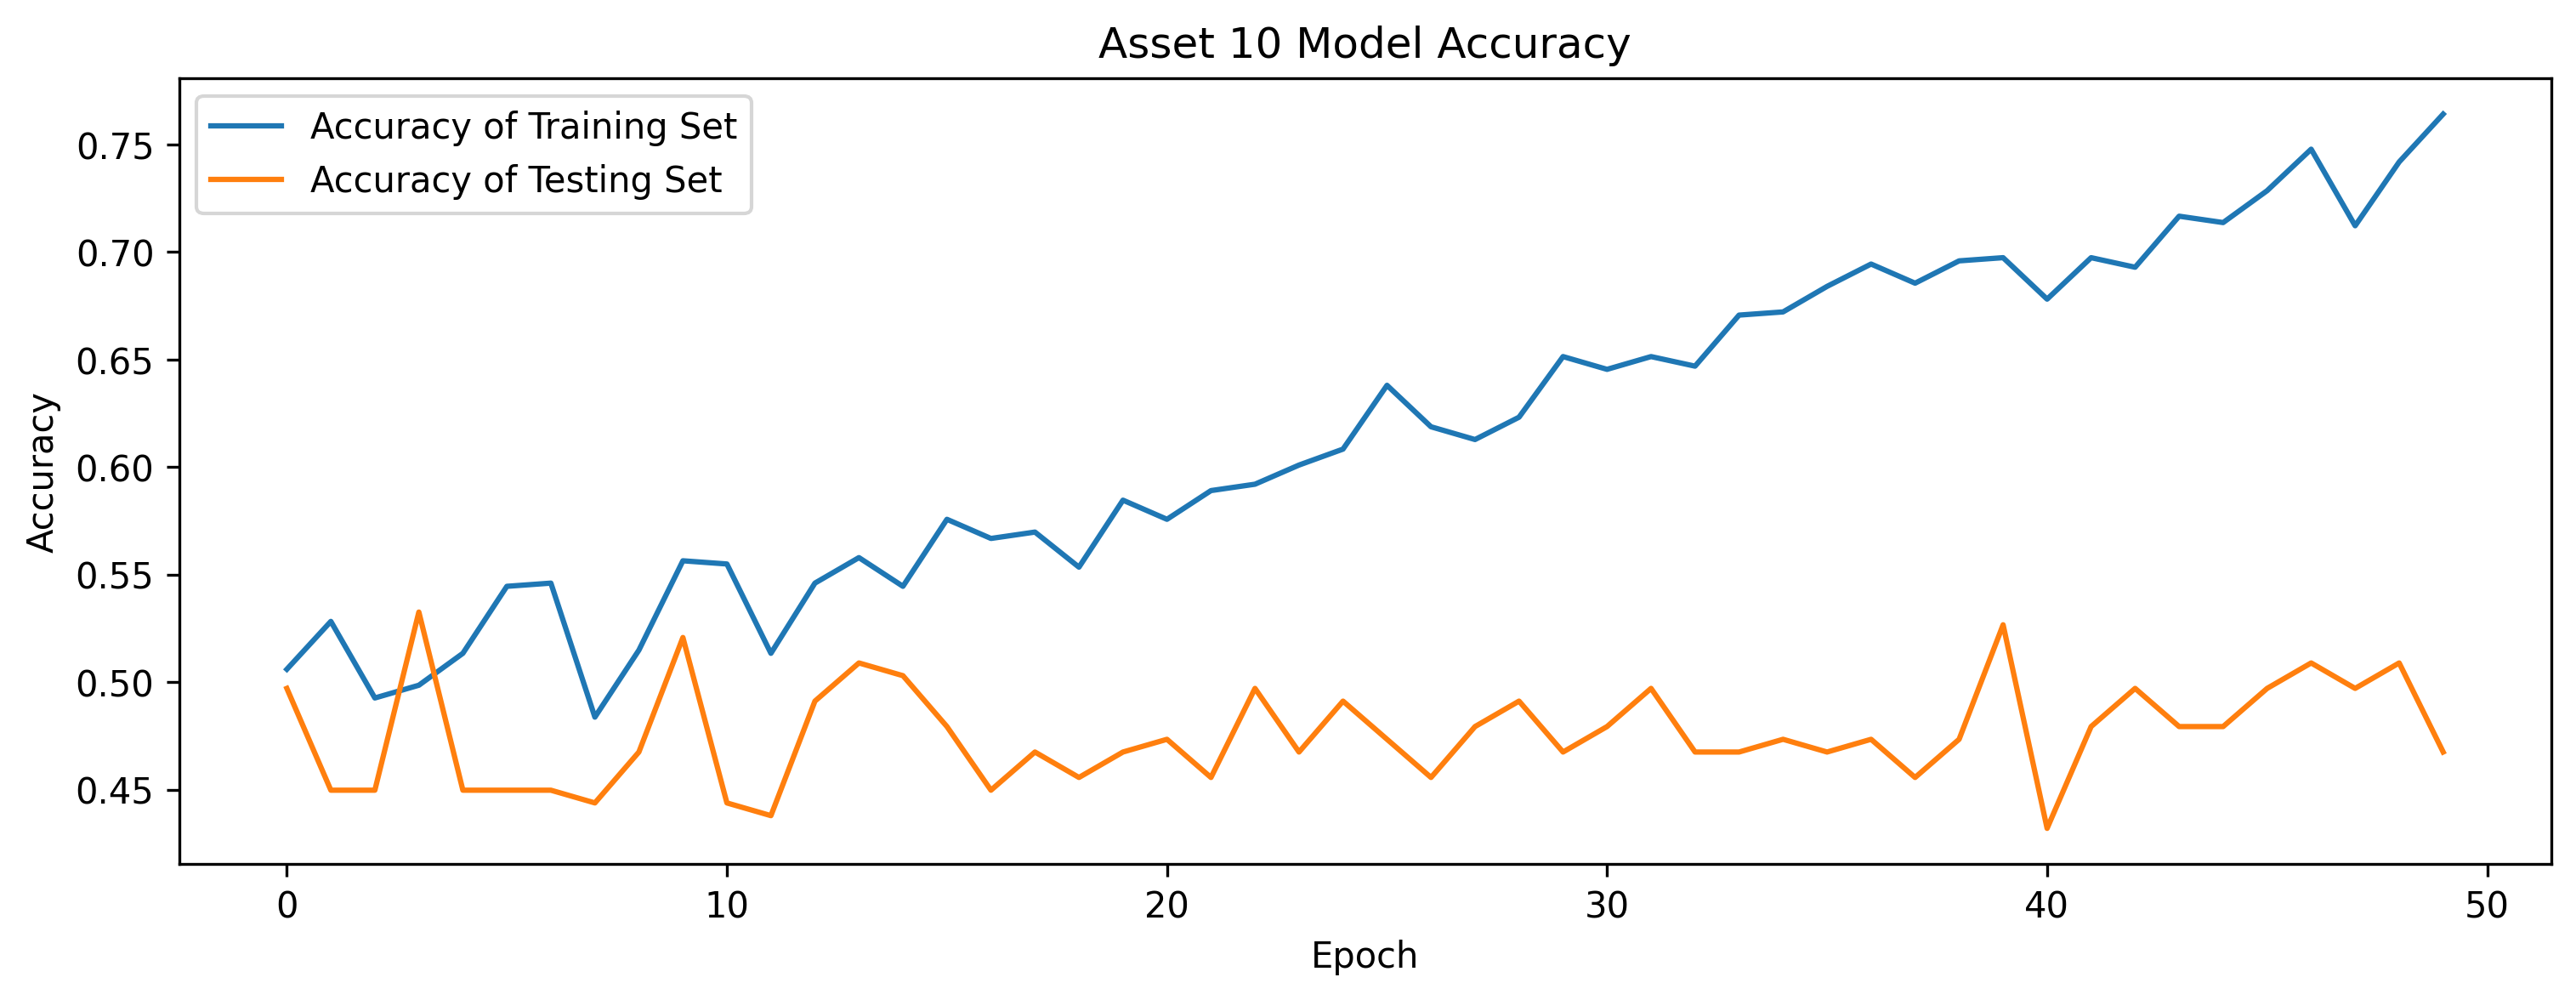


Processing Asset 11 ...
Asset 11 - Loss of the testing set: 0.8972, Accuracy: 0.4550
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


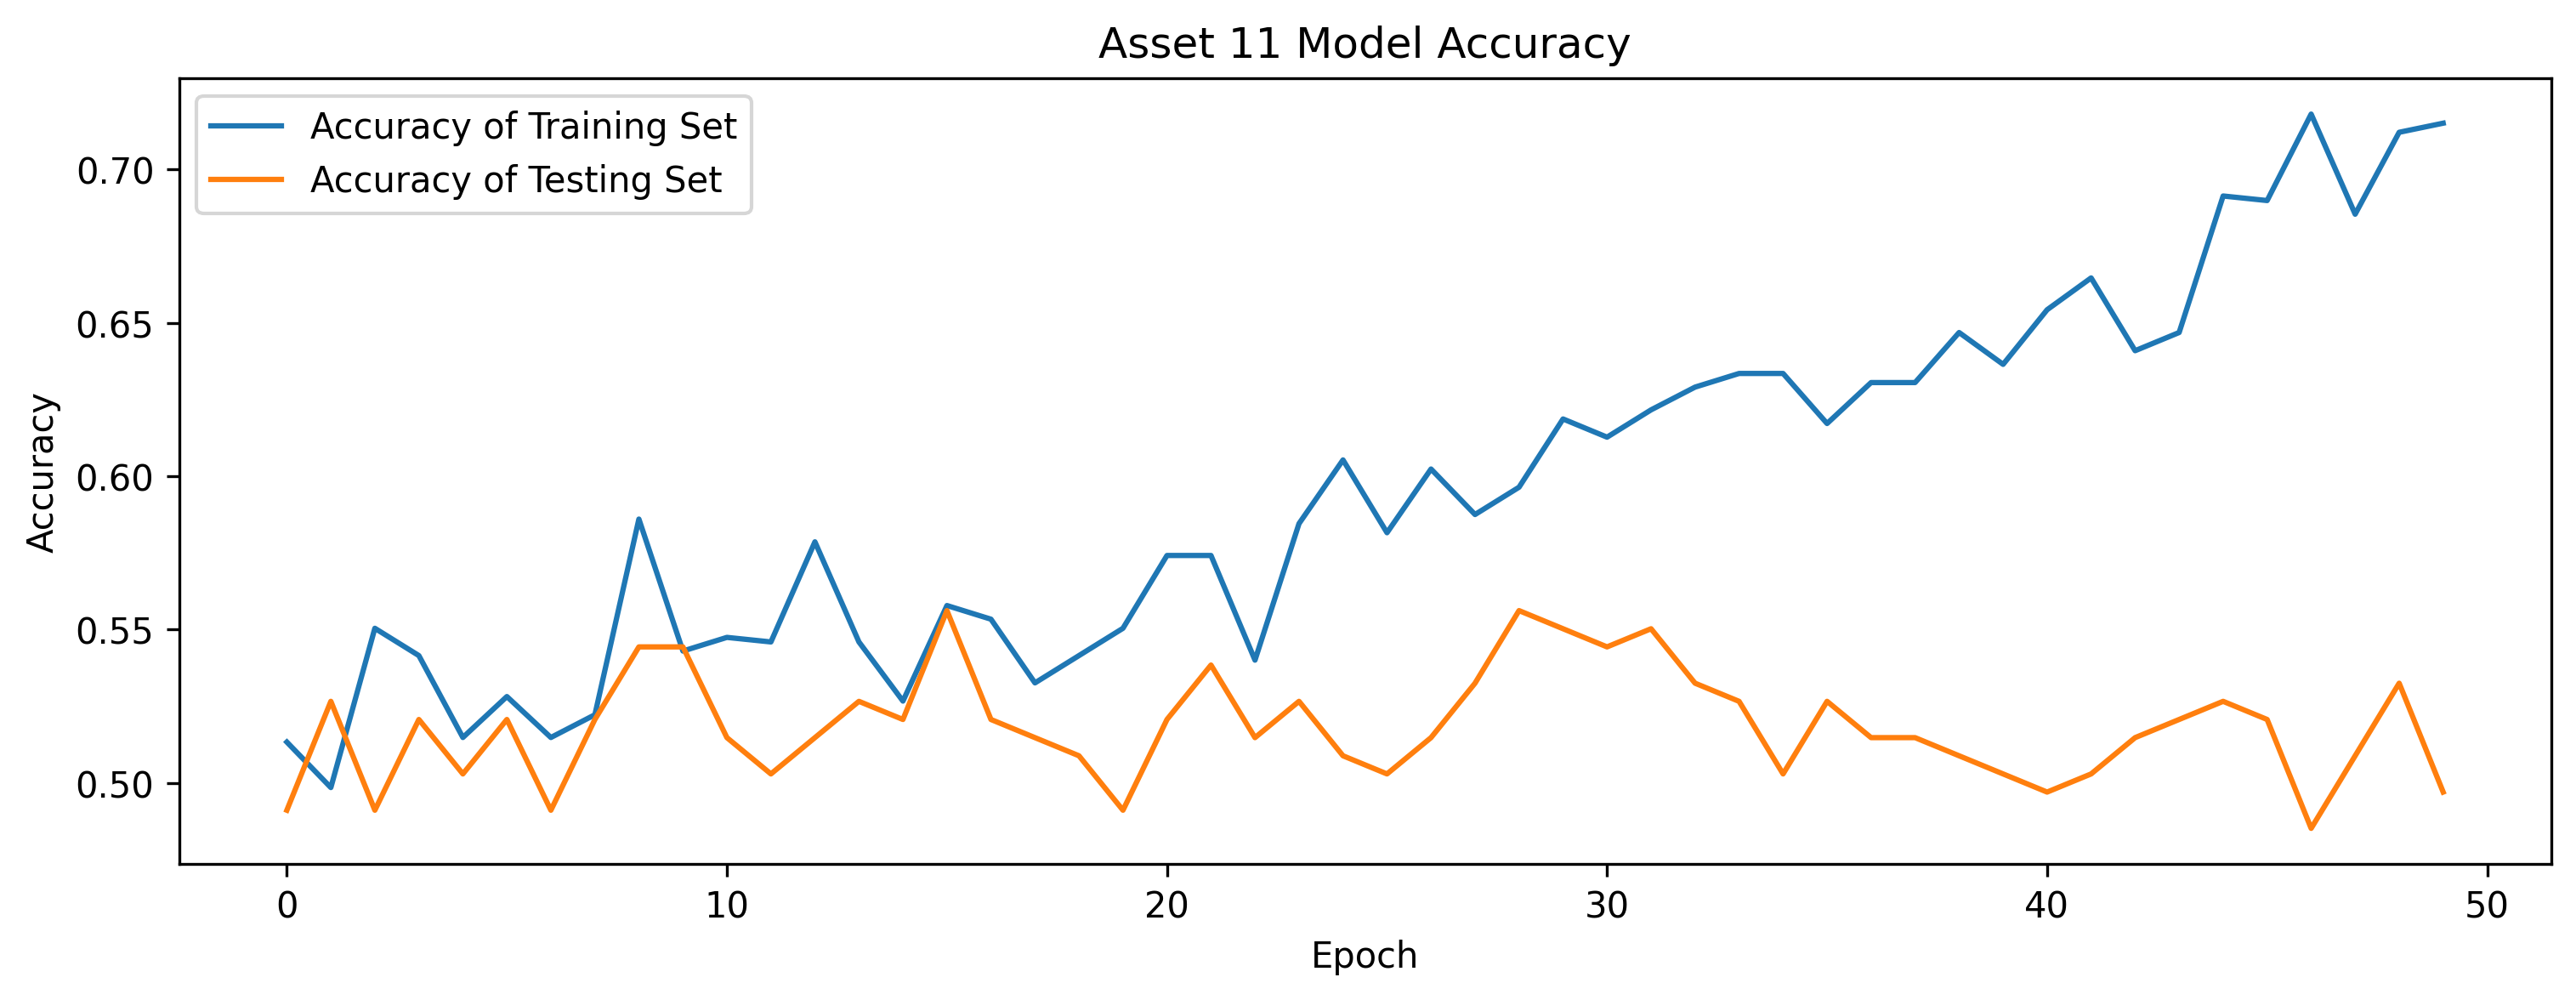

In [97]:
for idx, asset in enumerate(assets):
    print(f'\nProcessing {asset} ...')

    # Define the target variable as the return for the following week
    target = df_target[asset].shift(-1).dropna()

    # Select columns that contain only numeric features
    current_features = features.loc[target.index, feature_columns]
    X, y = create_sequences(current_features.values, target.values, sequence_length)

    # Filtering NA values one more time
    valid_indices = ~np.isnan(y)
    X = X[valid_indices]
    y = y[valid_indices]

    # Target variables converted to binary: 1 for positive returns and 0 for negative returns
    y = (y > 0).astype(int)

    # Manually split training and test sets (80% training, 20% testing)
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Get the dates corresponding to the testing set
    if test_dates is None:
        # The date of the target variable corresponds to the last point in the sequence
        target_dates = current_features.index[sequence_length:]
        test_dates = target_dates[-len(X_test):]

    # Feature scaling (normalization)
    # Start by scaling the training set data
    # Scale the test set using the same scaling parameters
    scaler = MinMaxScaler()
    X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
    X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)

    X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
    X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

    # Save the scaler
    scalers[asset] = scaler

    # Build the RNN model
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(50))
    model.add(Dense(1, activation='sigmoid'))  # Dichotomized output

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        epochs=50,  # Epochs of traing - can be adjusted manually
        batch_size=128,  # Batch size - can be adjuste manually
        validation_split=0.2,  # Ratio of the validation set
        verbose=0  # Training progress
    )

    models[asset] = model
    histories[asset] = history

    # Evaluating model performance on a test set
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f'{asset} - Loss of the testing set: {loss:.4f}, Accuracy: {accuracy:.4f}')

    # Predicting based on the training set
    pred_prob = model.predict(X_test_scaled).flatten()
    predictions[asset] = pred_prob

    # Convert probabilities to binary predictions (1 or 0)
    pred_binary = (pred_prob > 0.5).astype(int)
    binary_predictions[asset] = pred_binary
    
    plt.figure(figsize=(12, 4), dpi=300)
    plt.plot(history.history['accuracy'], label='Accuracy of Training Set')
    plt.plot(history.history['val_accuracy'], label='Accuracy of Testing Set')
    plt.title(f'{asset} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


## Asset Ranking Based on the ML Outcomes and Dynamic Risk Levels

In [102]:
display(binary_predictions['Asset 1'], binary_predictions['Asset 2'])

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1])

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [103]:
test_dates

DatetimeIndex(['2020-05-22', '2020-06-01', '2020-06-08', '2020-06-15',
               '2020-06-22', '2020-06-29', '2020-07-06', '2020-07-13',
               '2020-07-20', '2020-07-27',
               ...
               '2024-04-01', '2024-04-08', '2024-04-15', '2024-04-22',
               '2024-04-29', '2024-05-06', '2024-05-13', '2024-05-20',
               '2024-05-24', '2024-06-03'],
              dtype='datetime64[ns]', name='Date', length=211, freq=None)

In [114]:
# Define the risk level selection mapping
risk_level_selection = {
    'Extremely High Risk': 2,
    'Moderately High Risk': 3,
    'Moderately Low Risk': 5,
    'Extremely Low Risk': 6
}

selected_assets_per_week = {}
for i, test_date in enumerate(test_dates):
    # Dictionary to temporarily store assets with positive returns and their risk levels
    positive_assets = []
    
    # Collect assets with positive returns on this date
    for asset, predictions in binary_predictions.items():
        if predictions[i] == 1:  # Positive return predicted
            final_data = final_df.reset_index()
            # Retrieve the risk level for this asset on the test date
            risk_level = final_data.loc[final_data['Date'] == test_date, 'Risk Level'].iloc[0]
            positive_assets.append((asset, risk_level))
    
    # Sort positive assets by risk level priority (low to high risk)
    positive_assets.sort(key=lambda x: list(risk_level_selection.keys()).index(x[1]))
    
    # Apply selection based on the risk level of the period's conditions
    for asset, risk_level in positive_assets:
        max_investments = risk_level_selection.get(risk_level, 0)
        if len(selected_assets_per_week.get(test_date, [])) < max_investments:
            selected_assets_per_week.setdefault(test_date, []).append(asset)

investment_details_df = pd.DataFrame([
    {"Date": date, "Investment Count": len(assets), "Assets": assets}
    for date, assets in selected_assets_per_week.items()
])

# Sorting by date to maintain chronological order
investment_details_df.sort_values(by="Date", inplace=True)
max_assets = max(len(assets) for assets in investment_details_df["Assets"])

# Create new columns for each possible asset position
for i in range(max_assets):
    investment_details_df[f"Asset_{i+1}"] = investment_details_df["Assets"].apply(lambda x: x[i] if i < len(x) else None)

investment_details_df = investment_details_df.drop(columns=["Assets"])
for i in range(1, max_assets + 1):
    investment_details_df.rename(columns={f"Asset_{i}": f"Selected_{i}"}, inplace=True)
investment_details_df

,Date,Investment Count,Selected_1,Selected_2,Selected_3,Selected_4,Selected_5,Selected_6
0,2020-05-22,2,Asset 1,Asset 3,None,None,None,None
1,2020-06-01,3,Asset 1,Asset 3,Asset 8,None,None,None
2,2020-06-08,2,Asset 3,Asset 4,None,None,None,None
3,2020-06-15,2,Asset 3,Asset 4,None,None,None,None
4,2020-06-22,2,Asset 1,Asset 3,None,None,None,None
...,...,...,...,...,...,...,...,...
206,2024-05-06,2,Asset 2,Asset 3,None,None,None,None
207,2024-05-13,2,Asset 2,Asset 3,None,None,None,None
208,2024-05-20,3,Asset 1,Asset 3,Asset 4,None,None,None
209,2024-05-24,5,Asset 3,Asset 4,Asset 5,Asset 6,Asset 7,None
